In [1]:
# Import Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly as py
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import fbprophet
from fbprophet import Prophet

# disable "future warnings"
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importing datasets
df=pd.read_csv('covid_19_data.csv')
df.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [3]:
# Dataset rows & columns
df.shape

(12249, 8)

In [4]:
df1 = df.groupby([ 'ObservationDate']).sum().reset_index().sort_values('ObservationDate', ascending=False)
df1 = df.drop_duplicates(subset = ['Country/Region'])
df1 = df[df['Confirmed']>0]

In [5]:
 #Confirmed cases visualization on a globally
fig = go.Figure(data=go.Choropleth(locations = df1['Country/Region'],locationmode = 'country names',z = df1['Confirmed'],
    colorscale = 'Reds',marker_line_color = 'black', marker_line_width = 0.5))

fig.update_layout(title_text = 'Confirmed Cases Globally',title_x = 0.5,geo=dict(showframe = False, 
                 showcoastlines = False,projection_type = 'equirectangular'))

In [6]:
# Groupping dataset w.r.t observation dates
data=  df.groupby('ObservationDate')[['Confirmed','Recovered','Deaths']].sum()
data.tail()

,Confirmed,Recovered,Deaths
ObservationDate,,,
04/01/2020,932605.0,193177.0,46809.0
04/02/2020,1013157.0,210263.0,52983.0
04/03/2020,1095917.0,225796.0,58787.0
04/04/2020,1197405.0,246152.0,64606.0
04/05/2020,1272115.0,260012.0,69374.0


In [7]:
cases = data.reset_index()
cases.tail()

,ObservationDate,Confirmed,Recovered,Deaths
70,04/01/2020,932605.0,193177.0,46809.0
71,04/02/2020,1013157.0,210263.0,52983.0
72,04/03/2020,1095917.0,225796.0,58787.0
73,04/04/2020,1197405.0,246152.0,64606.0
74,04/05/2020,1272115.0,260012.0,69374.0


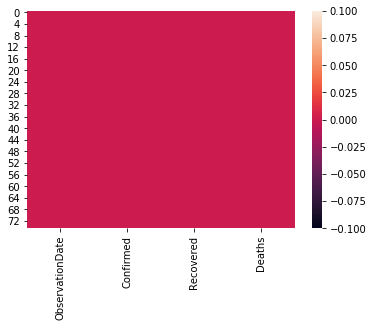

In [8]:
sns.heatmap(cases.isnull())

In [9]:
cases.describe()

,Confirmed,Recovered,Deaths
count,7.500000e+01,75.000000,75.00000
mean,2.148836e+05,56329.933333,9686.92000
std,3.061862e+05,64365.355321,16119.06309
min,5.550000e+02,28.000000,17.00000
25%,4.145700e+04,3595.000000,959.50000
50%,8.412400e+04,36711.000000,2872.00000
75%,2.060415e+05,82076.500000,8319.00000
max,1.272115e+06,260012.000000,69374.00000


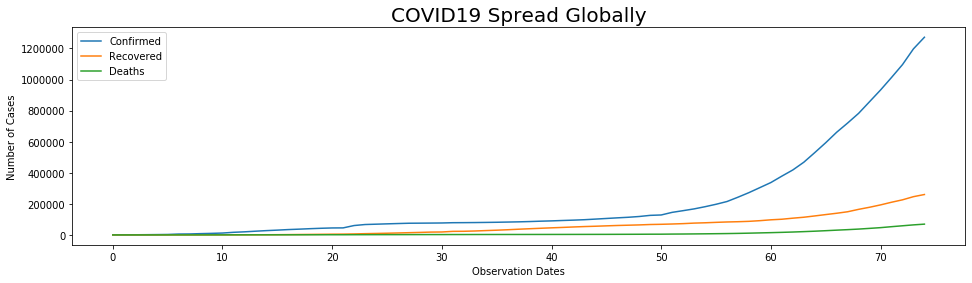

In [10]:
# Visualization No of different cases in our data. 
cases.plot(kind='line',figsize=(16,4))
plt.xlabel('Observation Dates')
plt.ylabel('Number of Cases')
plt.title('COVID19 Spread Globally',fontsize=20);

# Time Series Forcasting by Prophet
forecast = Prophet(interval_width=0.95).fit(df).predict(future)

In [215]:
# Model Initialize or set prophet model 
model= Prophet(interval_width=0.80 ,changepoint_prior_scale=0.15)

In [216]:
model.add_seasonality(name='monthly', period=30 , fourier_order=5)

In [217]:
confirmed_cases = cases[['ObservationDate','Confirmed']]

In [218]:
confirmed_cases.shape

(75, 2)

In [219]:
#Prophet looks for two fields from input data: time ds and values y so convert values to given format
confirmed_cases.rename(columns={'ObservationDate':'ds', 'Confirmed':'y'},inplace=True)
               

In [220]:
# Breaking dataset into train and test
confirmed_train = confirmed_cases[ :65]
confirmed_test = confirmed_cases[65 : ]

In [221]:
confirmed_train.tail()

,ds,y
60,03/22/2020,337020.0
61,03/23/2020,378287.0
62,03/24/2020,417966.0
63,03/25/2020,467594.0
64,03/26/2020,529591.0


In [222]:
# Fitting the prophet model:
model.fit(confirmed_train) ;

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [223]:
# build a dataframe on to fit daily predictions period
future_dates = model.make_future_dataframe(periods=45)
future_dates.tail()

,ds
105,2020-05-06
106,2020-05-07
107,2020-05-08
108,2020-05-09
109,2020-05-10


In [224]:
prediction_days = model.predict(future_dates)
prediction_days.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,monthly_lower,monthly_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
105,2020-05-06,1.742790e+06,989385.906192,2.587902e+06,937382.255395,2.532945e+06,53451.262747,53451.262747,53451.262747,57872.376479,57872.376479,57872.376479,-4421.113732,-4421.113732,-4421.113732,0.0,0.0,0.0,1.796242e+06
106,2020-05-07,1.772409e+06,992053.863529,2.639493e+06,942015.463385,2.591067e+06,50015.671232,50015.671232,50015.671232,49053.465577,49053.465577,49053.465577,962.205655,962.205655,962.205655,0.0,0.0,0.0,1.822424e+06
107,2020-05-08,1.802027e+06,987729.164652,2.696624e+06,942741.153563,2.651064e+06,44925.493174,44925.493174,44925.493174,39927.055779,39927.055779,39927.055779,4998.437395,4998.437395,4998.437395,0.0,0.0,0.0,1.846953e+06
108,2020-05-09,1.831645e+06,973824.922650,2.735927e+06,939040.786296,2.701792e+06,34196.385011,34196.385011,34196.385011,29936.688558,29936.688558,29936.688558,4259.696453,4259.696453,4259.696453,0.0,0.0,0.0,1.865842e+06
109,2020-05-10,1.861264e+06,958145.389586,2.781661e+06,938881.538682,2.761972e+06,19943.063130,19943.063130,19943.063130,18472.140603,18472.140603,18472.140603,1470.922527,1470.922527,1470.922527,0.0,0.0,0.0,1.881207e+06


In [225]:
prediction_days[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
105,2020-05-06,1.796242e+06,989385.906192,2.587902e+06
106,2020-05-07,1.822424e+06,992053.863529,2.639493e+06
107,2020-05-08,1.846953e+06,987729.164652,2.696624e+06
108,2020-05-09,1.865842e+06,973824.922650,2.735927e+06
109,2020-05-10,1.881207e+06,958145.389586,2.781661e+06


Text(0.5, 1, 'Number of Confirmed Cases Over Time')

<Figure size 576x288 with 0 Axes>

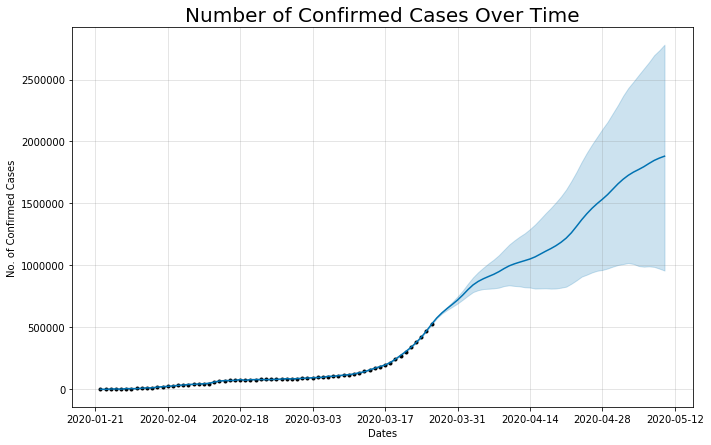

In [226]:
# Ploting and visualize the predicted forecast

plt.figure(figsize=(8,4))
model.plot(prediction_days,  xlabel='Dates',ylabel='No. of Confirmed Cases' );
plt.title('Number of Confirmed Cases Over Time',fontsize=20)

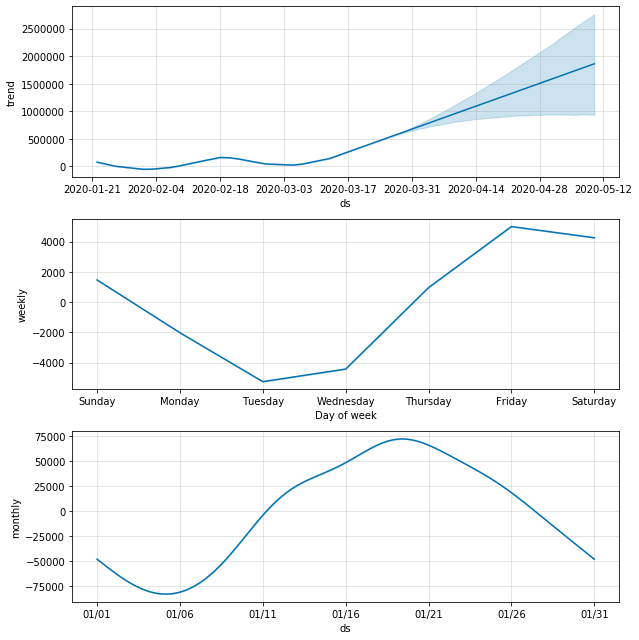

In [227]:
# Plotting model components
model.plot_components(prediction_days);


In [228]:
confirmed_test.tail()

,ds,y
70,04/01/2020,932605.0
71,04/02/2020,1013157.0
72,04/03/2020,1095917.0
73,04/04/2020,1197405.0
74,04/05/2020,1272115.0


In [229]:
## Convert to datetime format
confirmed_test['dates']= pd.to_datetime(confirmed_test['ds'])

In [230]:
confirmed_test.tail()

,ds,y,dates
70,04/01/2020,932605.0,2020-04-01
71,04/02/2020,1013157.0,2020-04-02
72,04/03/2020,1095917.0,2020-04-03
73,04/04/2020,1197405.0,2020-04-04
74,04/05/2020,1272115.0,2020-04-05


In [231]:
confirmed_test = confirmed_test.set_index('dates')

In [232]:
confirmed_test = confirmed_test['y']

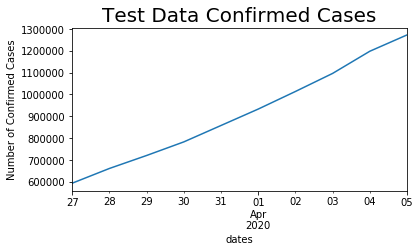

In [233]:
plt.figure(figsize=(6,3))
plt.xlabel('Observation Dates')
plt.ylabel('Number of Confirmed Cases')
plt.title('Test Data Confirmed Cases',fontsize=20);
confirmed_test.plot()

In [234]:
# Find points
from fbprophet.plot import add_changepoints_to_plot

[[<matplotlib.lines.Line2D at 0x1df847b2208>],

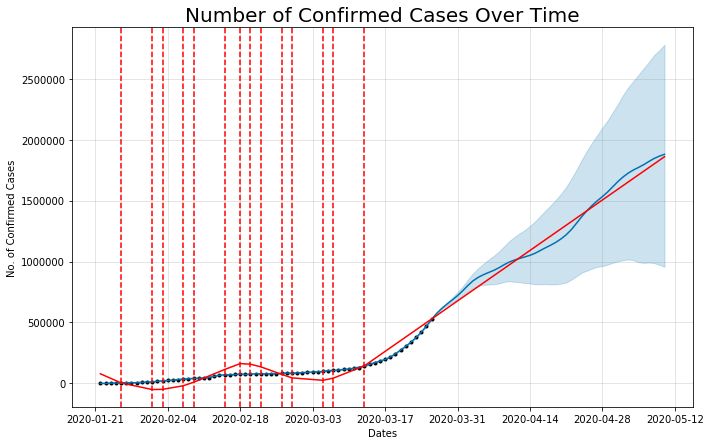

In [235]:
fig=model.plot(prediction_days, xlabel='Dates',ylabel='No. of Confirmed Cases')
plt.title('Number of Confirmed Cases Over Time',fontsize=20)

add_changepoints_to_plot(fig.gca(), model,prediction_days)

In [236]:
from fbprophet.diagnostics import cross_validation

In [237]:
confirmed_train.shape

(65, 2)

In [238]:
from fbprophet.diagnostics import cross_validation
cv = cross_validation(model, initial='30 days', period='5 days', horizon = '5 days')
cv.head()

INFO:fbprophet:Making 6 forecasts with cutoffs between 2020-02-25 00:00:00 and 2020-03-21 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-02-26,80476.318900,79086.370288,81743.856487,81397.0,2020-02-25
1,2020-02-27,82563.737007,81253.182113,84126.278529,82756.0,2020-02-25
2,2020-02-28,83166.493815,81654.673822,84557.303825,84124.0,2020-02-25
3,2020-02-29,84360.589859,82976.599769,85732.590700,86013.0,2020-02-25
4,2020-03-01,87643.886437,86362.405493,89134.884330,88371.0,2020-02-25


In [239]:
# Evaluate model performance
from fbprophet.diagnostics import performance_metrics
pm = performance_metrics(cv)
pm

,horizon,mse,rmse,mae,mape,mdape,coverage
0,1 days,5.063867e+07,7116.085283,4727.061367,0.022788,0.016533,0.500000
1,2 days,4.312384e+08,20766.281314,13847.744936,0.058573,0.060663,0.333333
2,3 days,1.373465e+09,37060.289898,23883.708734,0.087327,0.066015,0.333333
3,4 days,3.360183e+09,57967.086048,37025.171942,0.122723,0.077733,0.000000
4,5 days,6.914701e+09,83154.679813,53166.360209,0.158446,0.120780,0.166667


Text(0.5, 1.0, 'mean absolute percent error (MAPE)')

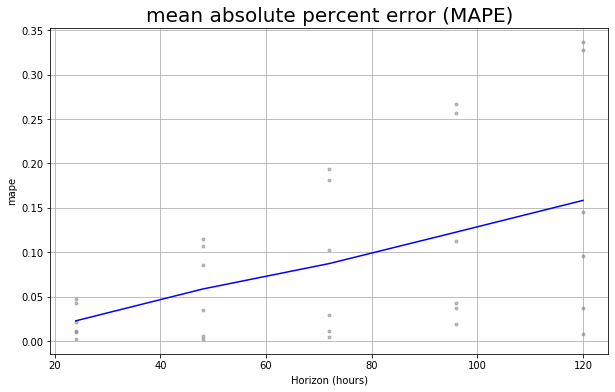

In [240]:
from fbprophet.plot import plot_cross_validation_metric

fig = plot_cross_validation_metric(cv, metric='mape')
plt.title('mean absolute percent error (MAPE)',fontsize=20)